In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *
from utils.analysis import *
from utils_custom.analysis import *


import matplotlib.pyplot as plt
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

SEED = 42
PATH_RESULTS = '../Results/'
TARGET_NAME = "site_eui"

seed_everything(SEED)
pd.set_option('display.max_columns', 100)

#PATH_DATASET = '../Dataset/'
PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

# loading dataset

In [2]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

In [3]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,item_id,date_block_num
0,2017-01-08,0,0,12,76,2,0_12_76,0
1,2017-01-08,0,0,12,149,3,0_12_149,0
2,2017-01-08,0,0,12,256,3,0_12_256,0
3,2017-01-08,0,0,12,354,3,0_12_354,0
4,2017-01-08,0,0,13,149,2,0_13_149,0


In [4]:
original_columns_sales = df_sales.columns
numeric_desc, categorical_desc = my_df_describe(df_sales,name = 'df_sales',show = True,path=PATH_RESULTS,save=False)

********************df_sales********************
shape  (2216312, 8)
**********numerics**********


,count,mean,std,min,25%,50%,75%,max,unique,nulls,nulls_perc
S100,2216312.0,15.081075,8.827836,0.0,8.0,15.0,23.0,30.0,31,0,0.0
I100,2216312.0,45.852576,27.634678,0.0,20.0,47.0,73.0,95.0,96,0,0.0
C100,2216312.0,13.520613,2.160282,0.0,13.0,14.0,14.0,20.0,21,0,0.0
C101,2216312.0,225.745576,117.144027,0.0,111.0,281.0,341.0,354.0,355,0,0.0
QTT,2216312.0,2.455864,3.332182,1.0,1.0,1.0,3.0,691.0,197,0,0.0
date_block_num,2216312.0,114.082241,82.569551,0.0,45.0,85.0,200.0,257.0,203,0,0.0


**********categorical**********


,count,unique,top,freq,first,last,nulls,nulls_perc
DATE,2216312,203,2017-12-24 00:00:00,22494,2017-01-08,2021-12-12,0,0.0
item_id,2216312,3781,50_14_29,4909,NaT,NaT,0,0.0


In [5]:
df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]

In [6]:
df_sales['DATE'] = pd.to_datetime(df_sales['DATE'], errors='coerce')
df_submission_sample['DATE'] = pd.to_datetime(df_submission_sample['DATE'], errors='coerce')

In [7]:
date = df_sales['DATE'].min()
maxi = df_submission_sample['DATE'].max()

dict_dates = {}
idx = 0
while(True):    
    if date>maxi:
        break
    dict_dates[date]=idx
    date = date+ pd.DateOffset(days=7)    
    idx = idx+1


In [8]:
df_sales.tail()

,DATE,S100,I100,C100,C101,QTT,item_id,date_block_num
2216307,2021-12-12,29,94,13,354,3,94_13_354,257
2216308,2021-12-12,29,94,14,354,3,94_14_354,257
2216309,2021-12-12,29,95,12,354,1,95_12_354,257
2216310,2021-12-12,29,95,13,354,2,95_13_354,257
2216311,2021-12-12,29,95,14,354,1,95_14_354,257


In [9]:
if True:
    sample_sales_unique_filename = os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl')

    if os.path.exists(sample_sales_unique_filename):
        print('already exist !')
        sample_sales_unique = pd.read_pickle(sample_sales_unique_filename)
    else:
        print('processing ..')
        sample_sales_unique  = get_sample_sales_unique(df_sales,df_submission_sample)
        print('saving ..')
        sample_sales_unique.to_pickle(os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl'))
        print('completed')


    sample_sales_unique['DATE'].min(),sample_sales_unique['DATE'].max()
    sample_sales_unique.head()


    print(sample_sales_unique.shape)

    df_auxiliar = sample_sales_unique.merge(df_sales,on=['DATE','S100','I100','C100','C101'],how='left')
    df_auxiliar.replace([np.inf, -np.inf,np.nan],0 , inplace=True)
    print(df_auxiliar.shape)
    df_auxiliar.head(2)

else:
    df_auxiliar  = df_sales

already exist !
(17992850, 5)
(17992850, 8)


In [10]:
df_auxiliar["item_id"] = df_auxiliar["I100"].astype(str) +"_"+ df_auxiliar["C100"].astype(str) +"_"+ df_auxiliar["C101"].astype(str) 

In [11]:
df_auxiliar['DATE'].min(),df_auxiliar['DATE'].max()

(Timestamp('2017-01-08 00:00:00'), Timestamp('2022-01-09 00:00:00'))

In [12]:
import time

start = time.time()
#df_auxiliar['date_block_num'] = df_auxiliar['DATE'].replace(dict_dates)
df_auxiliar['date_block_num'] = df_auxiliar['DATE'].map(dict_dates)
print('time : ',time.time()-start)

time :  1.0089240074157715


In [13]:
df_auxiliar.head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num
0,0,0,12,76,2017-01-08,2.0,0_12_76,0
1,0,0,12,76,2017-01-15,1.0,0_12_76,1
2,0,0,12,76,2017-01-22,1.0,0_12_76,2
3,0,0,12,76,2017-01-29,1.0,0_12_76,3
4,0,0,12,76,2017-02-05,2.0,0_12_76,4


In [14]:
df_auxiliar['DATE'].min(),df_auxiliar['DATE'].max()

(Timestamp('2017-01-08 00:00:00'), Timestamp('2022-01-09 00:00:00'))

In [15]:
df_auxiliar['date_block_num'].min(),df_auxiliar['date_block_num'].max()

(0, 261)

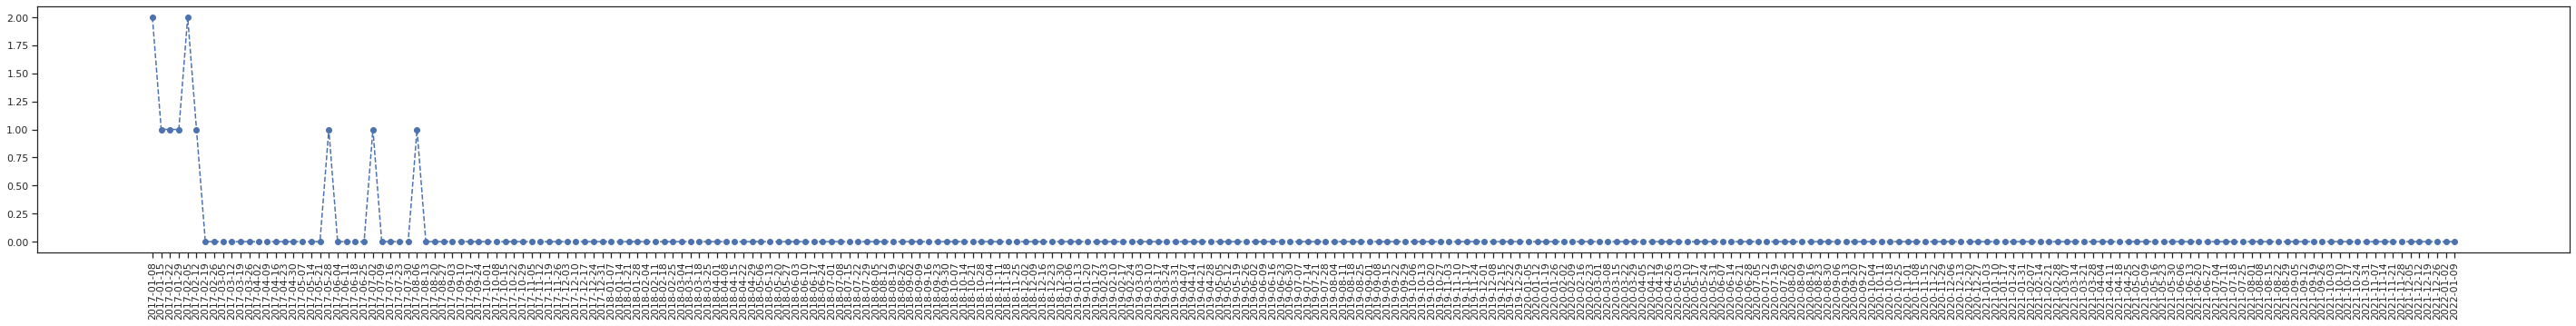

In [16]:
sub_group = get_store_item(df_auxiliar,0,0,12,76)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

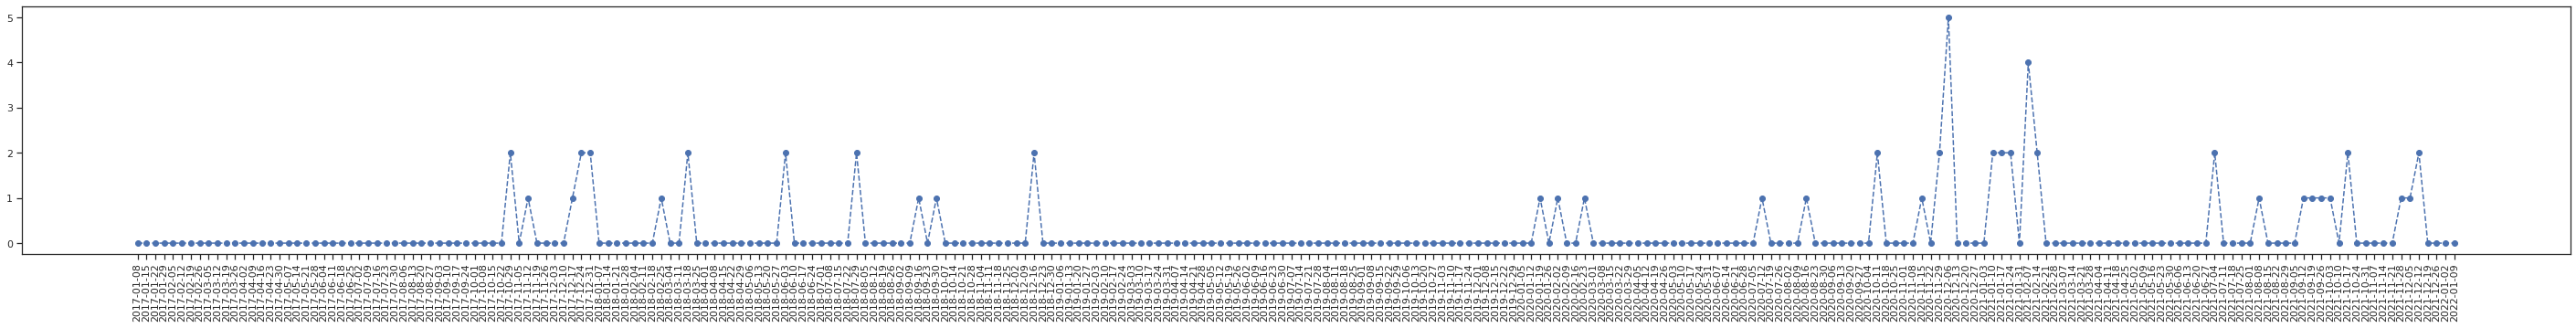

In [17]:
sub_group = get_store_item(df_auxiliar,0,1,12,140)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [18]:
########################### Product Release date
#################################################################################
print('Release week')

# It seems that leadings zero values
# in each train_df item row
# are not real 0 sales but mean
# absence for the item in the store
# we can safe some memory by removing
# such zeros

# Prices are set by week
# so it we will have not very accurate release week 
release_df = df_sales[['S100','item_id','date_block_num']].groupby(['S100','item_id'])['date_block_num'].agg(['min']).reset_index()
release_df.columns = ['S100','item_id','release']

print('1 df_auxiliar',df_auxiliar.shape)
# Now we can merge release_df
df_auxiliar = merge_by_concat(df_auxiliar, release_df, ['S100','item_id'])
print('2 df_auxiliar',df_auxiliar.shape)
del release_df

Release week
1 df_auxiliar (17992850, 8)
2 df_auxiliar (17992850, 9)


In [19]:
df_auxiliar[df_auxiliar['date_block_num']==254].head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
254,0,0,12,76,2021-11-21,0.0,0_12_76,254,0
516,0,0,12,149,2021-11-21,0.0,0_12_149,254,0
778,0,0,12,256,2021-11-21,0.0,0_12_256,254,0
1040,0,0,12,354,2021-11-21,0.0,0_12_354,254,0
1302,0,0,12,79,2021-11-21,0.0,0_12_79,254,36


In [20]:
sub_group = get_store_item(df_auxiliar,0,0,12,76)


In [21]:
sub_group

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
0,0,0,12,76,2017-01-08,2.0,0_12_76,0,0
1,0,0,12,76,2017-01-15,1.0,0_12_76,1,0
2,0,0,12,76,2017-01-22,1.0,0_12_76,2,0
3,0,0,12,76,2017-01-29,1.0,0_12_76,3,0
4,0,0,12,76,2017-02-05,2.0,0_12_76,4,0
...,...,...,...,...,...,...,...,...,...
257,0,0,12,76,2021-12-12,0.0,0_12_76,257,0
258,0,0,12,76,2021-12-19,0.0,0_12_76,258,0
259,0,0,12,76,2021-12-26,0.0,0_12_76,259,0
260,0,0,12,76,2022-01-02,0.0,0_12_76,260,0


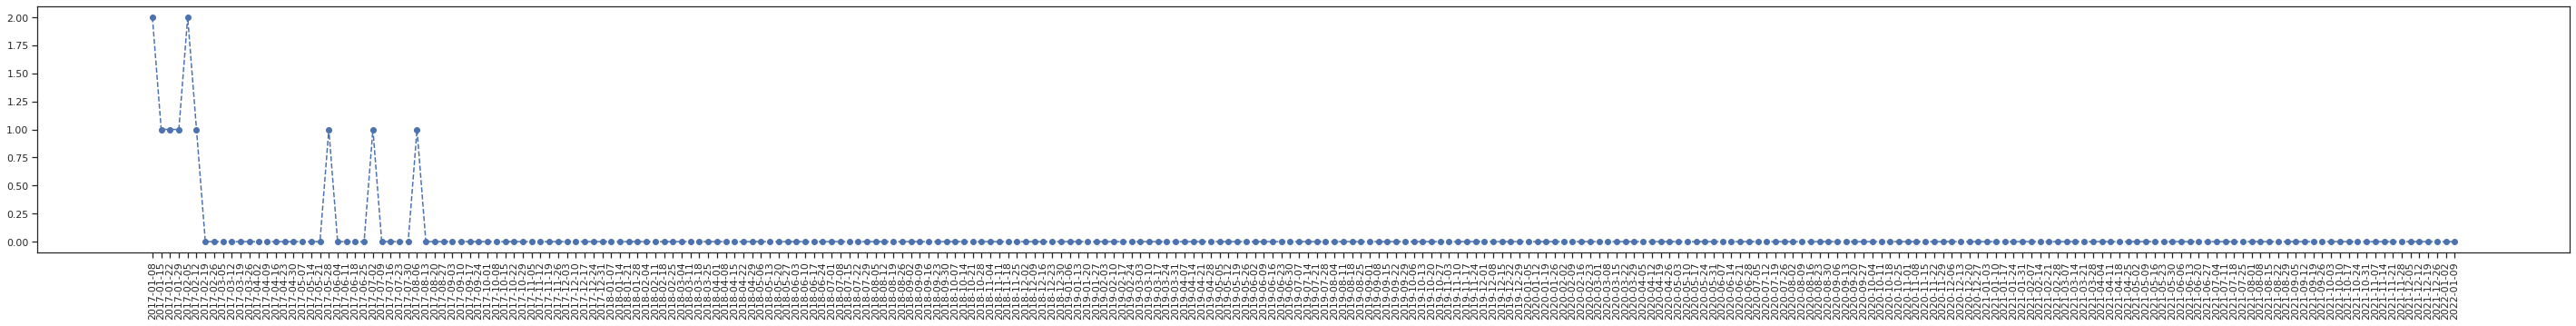

In [22]:
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [23]:
# and safe memory 

df_auxiliar = df_auxiliar[df_auxiliar['date_block_num']>=df_auxiliar['release']]
df_auxiliar = df_auxiliar.reset_index(drop=True)
print('3 df_auxiliar',df_auxiliar.shape)

df_auxiliar['release'] = df_auxiliar['release'] - df_auxiliar['release'].min()
df_auxiliar['release'] = df_auxiliar['release'].astype(np.int16)

3 df_auxiliar (14623646, 9)


In [24]:
import gc

gc.collect()

45

In [25]:
########################### Save part 1
#################################################################################
print('Save Part 1')

# We have our BASE grid ready
# and can save it as pickle file
# for future use (model training)
df_auxiliar.to_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))

print('Size:', df_auxiliar.shape)

Save Part 1
Size: (14623646, 9)


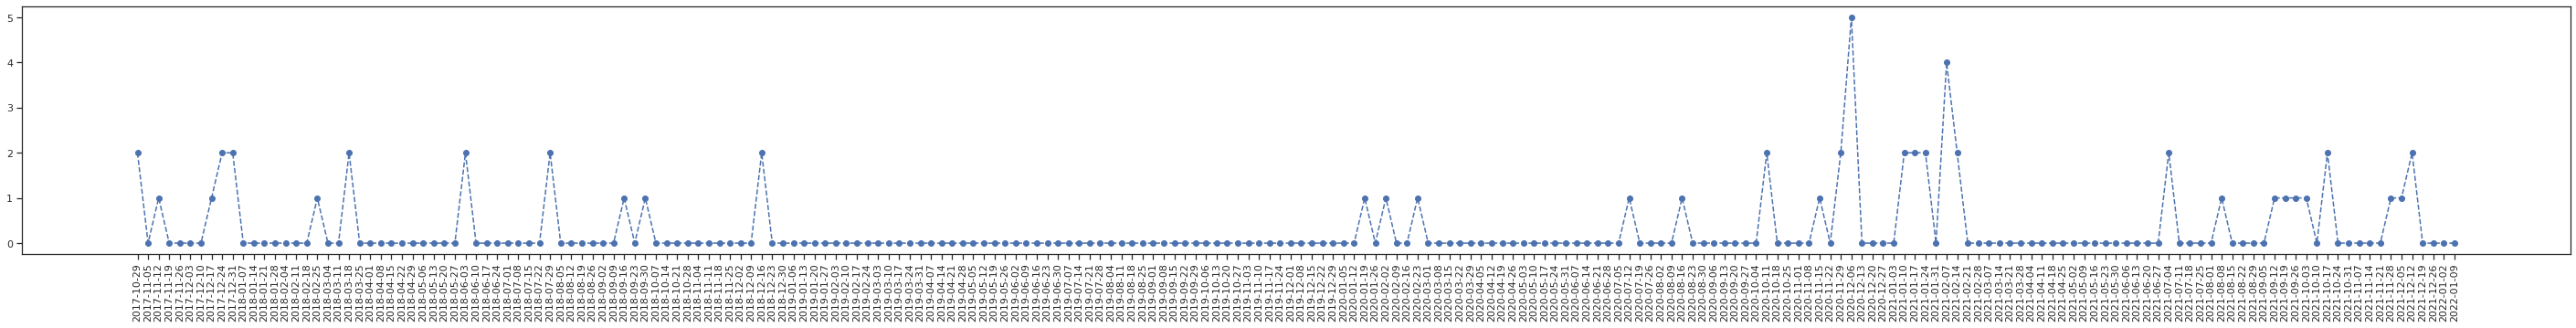

In [26]:
sub_group = get_store_item(df_auxiliar,0,1,12,140)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [27]:
TARGET = 'QTT'         # Our main target

In [28]:
########################### Vars
#################################################################################
TARGET = 'QTT'         # Our main target
END_TRAIN = df_auxiliar['date_block_num'].max()         # Last day in train set

In [29]:
MAIN_INDEX = ['S100','item_id','date_block_num']  # We can identify item by these columns
print('TARGET     :',TARGET)
print('END_TRAIN  :',END_TRAIN)
print('MAIN_INDEX :',MAIN_INDEX)

TARGET     : QTT
END_TRAIN  : 261
MAIN_INDEX : ['S100', 'item_id', 'date_block_num']


In [30]:
START_TRAIN = df_auxiliar['date_block_num'].min()         # First day in train set
print('START_TRAIN  :',START_TRAIN)


START_TRAIN  : 0


In [31]:
df_auxiliar = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))

df_auxiliar = df_auxiliar[['DATE', 'S100', 'item_id', 'date_block_num']]
print('df_auxiliar',df_auxiliar.shape)
df_auxiliar             = fe_dates(df_auxiliar)

df_auxiliar['tm_wm'] = df_auxiliar['day'].apply(lambda x: ceil(x/7)).astype(np.int8) # 오늘 몇째주?
df_auxiliar['tm_w_end'] = (df_auxiliar['day_of_week']>=5).astype(np.int8)
df_auxiliar['tm_m_end'] = (df_auxiliar['tm_wm']>=3).astype(np.int8)
del df_auxiliar['DATE']

df_auxiliar (14623646, 4)


In [32]:
gc.collect()

22856

In [33]:
df_auxiliar.head(1)

,S100,item_id,date_block_num,year,month,day,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end,tm_wm,tm_w_end,tm_m_end
0,0,0_12_76,0,2017,1,8,6,8,False,False,False,False,2,1,0


In [34]:
########################### Save part 3 (Dates)
#################################################################################
print('Save part 2')

# Safe part 3
df_auxiliar.to_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_2.pkl'))
print('Size:', df_auxiliar.shape)

# We don't need calendar_df anymore
del df_auxiliar

Save part 2
Size: (14623646, 15)


In [35]:
grid_df = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))

In [36]:
grid_df = grid_df.reset_index(drop=True)


In [37]:
grid_df[grid_df['release']==30].head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
76421,0,15,12,77,2017-08-06,1.0,15_12_77,30,30
76422,0,15,12,77,2017-08-13,0.0,15_12_77,31,30
76423,0,15,12,77,2017-08-20,0.0,15_12_77,32,30
76424,0,15,12,77,2017-08-27,0.0,15_12_77,33,30
76425,0,15,12,77,2017-09-03,0.0,15_12_77,34,30


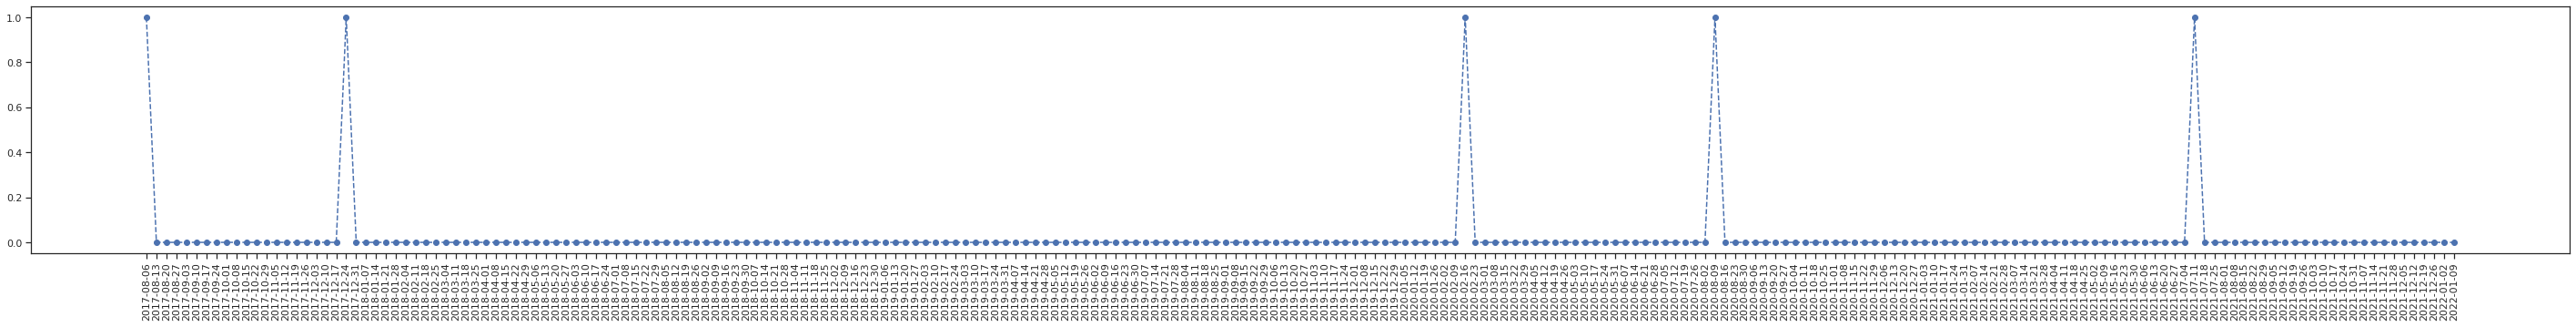

In [38]:
sub_group = get_store_item(grid_df,0,15,12,77)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [39]:
grid_df[grid_df['date_block_num']==246].head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
246,0,0,12,76,2021-09-26,0.0,0_12_76,246,0
508,0,0,12,149,2021-09-26,0.0,0_12_149,246,0
770,0,0,12,256,2021-09-26,0.0,0_12_256,246,0
1032,0,0,12,354,2021-09-26,0.0,0_12_354,246,0
1258,0,0,12,79,2021-09-26,0.0,0_12_79,246,36


In [40]:
grid_df['date_block_num'].max()

261

In [43]:
grid_df = grid_df[['date_block_num','S100','item_id','QTT']]
SHIFT_DAY = 3
WINDOW = 10
#WINDOW = 1

# Lags
# with 28 day shift
start_time = time.time()
print('Create lags')

LAG_DAYS = [col for col in range(SHIFT_DAY,SHIFT_DAY+WINDOW)]
print('len LAG_DAYS',len(LAG_DAYS))
grid_df = grid_df.assign(**{
        '{}_lag_{}'.format(col, l): grid_df.groupby(['S100','item_id'])[col].transform(lambda x: x.shift(l))
        for l in LAG_DAYS
        for col in [TARGET]
    })

Create lags
len LAG_DAYS 10


In [44]:
print('grid_df',grid_df.shape)

grid_df (14623646, 14)


In [45]:
grid_df.replace([np.inf, -np.inf, np.nan],0,inplace=True)
grid_df = grid_df.reset_index(drop=True)

In [46]:
sub_group = grid_df[(grid_df['S100']==0)&(grid_df['item_id']=='0_12_76')]
sub_group.head()

,date_block_num,S100,item_id,QTT,QTT_lag_3,QTT_lag_4,QTT_lag_5,QTT_lag_6,QTT_lag_7,QTT_lag_8,QTT_lag_9,QTT_lag_10,QTT_lag_11,QTT_lag_12
0,0,0,0_12_76,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0_12_76,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0_12_76,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
import gc
gc.collect()

0

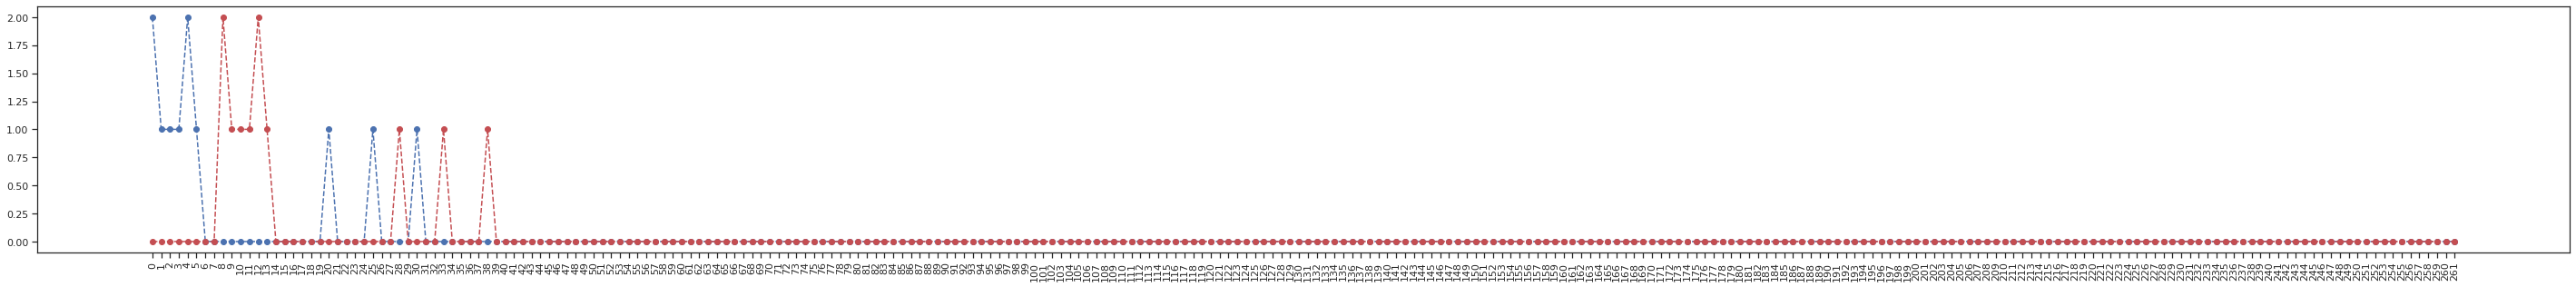

In [48]:
fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--ob')
plt.plot(sub_group.index,sub_group['QTT_lag_8'],'--or')
plt.xticks(sub_group.index, sub_group['date_block_num'].astype(str), rotation=90)
plt.show()



In [49]:

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,21]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)] = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)]  = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        grid_df[col_name] = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

3.67 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 21
Shifting period: 1
Shifting period: 7
Shifting period: 14
6.85 min: Lags


In [50]:
grid_df[['I100', 'C100', 'C101']] = grid_df['item_id'].str.split('_',expand=True)

In [51]:
icols =  [
            ['S100'],
            ['I100'],
            ['C100'],
            ['C101'],
            #['S100', 'C100'],
            #['S100', 'C100'],
            #['I100', 'C101'],
            ['I100', 'S100'],
            ['I100', 'C100','C101'],
            ]

In [52]:
# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')


for i in [7,14,21]:
    print('Rolling period:', i)
    for group_columns in icols:
        print('doing ..',group_columns)
        grid_df['rolling_mean_I100_'+str(i)+'_'+'_'.join(group_columns)] = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
        grid_df['rolling_std_I100_'+str(i)+'_'+'_'.join(group_columns)]  = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14]:
        col_name = 'rolling_mean_tmp_I100_'+str(d_shift)+'_'+str(d_window)
        for group_columns in icols:
            print('doing ..',group_columns)            
            grid_df[col_name+'_'+'_'.join(group_columns)] = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create rolling aggs
Rolling period: 7
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Rolling period: 14
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Rolling period: 21
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Shifting period: 1
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Shifting period: 7
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S10

In [54]:
grid_df.head()

,date_block_num,S100,item_id,QTT,QTT_lag_3,QTT_lag_4,QTT_lag_5,QTT_lag_6,QTT_lag_7,QTT_lag_8,QTT_lag_9,QTT_lag_10,QTT_lag_11,QTT_lag_12,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_21,rolling_std_21,rolling_mean_tmp_1_7,rolling_mean_tmp_1_14,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_I100_7_S100,rolling_std_I100_7_S100,rolling_mean_I100_7_I100,rolling_std_I100_7_I100,rolling_mean_I100_7_C100,rolling_std_I100_7_C100,rolling_mean_I100_7_C101,rolling_std_I100_7_C101,rolling_mean_I100_7_I100_S100,rolling_std_I100_7_I100_S100,rolling_mean_I100_7_I100_C100_C101,rolling_std_I100_7_I100_C100_C101,rolling_mean_I100_14_S100,rolling_std_I100_14_S100,rolling_mean_I100_14_I100,rolling_std_I100_14_I100,rolling_mean_I100_14_C100,rolling_std_I100_14_C100,rolling_mean_I100_14_C101,rolling_std_I100_14_C101,rolling_mean_I100_14_I100_S100,rolling_std_I100_14_I100_S100,rolling_mean_I100_14_I100_C100_C101,rolling_std_I100_14_I100_C100_C101,rolling_mean_I100_21_S100,rolling_std_I100_21_S100,rolling_mean_I100_21_I100,rolling_std_I100_21_I100,rolling_mean_I100_21_C100,rolling_std_I100_21_C100,rolling_mean_I100_21_C101,rolling_std_I100_21_C101,rolling_mean_I100_21_I100_S100,rolling_std_I100_21_I100_S100,rolling_mean_I100_21_I100_C100_C101,rolling_std_I100_21_I100_C100_C101,rolling_mean_tmp_I100_1_7_S100,rolling_mean_tmp_I100_1_7_I100,rolling_mean_tmp_I100_1_7_C100,rolling_mean_tmp_I100_1_7_C101,rolling_mean_tmp_I100_1_7_I100_S100,rolling_mean_tmp_I100_1_7_I100_C100_C101,rolling_mean_tmp_I100_1_14_S100,rolling_mean_tmp_I100_1_14_I100,rolling_mean_tmp_I100_1_14_C100,rolling_mean_tmp_I100_1_14_C101,rolling_mean_tmp_I100_1_14_I100_S100,rolling_mean_tmp_I100_1_14_I100_C100_C101,rolling_mean_tmp_I100_7_7_S100,rolling_mean_tmp_I100_7_7_I100,rolling_mean_tmp_I100_7_7_C100,rolling_mean_tmp_I100_7_7_C101,rolling_mean_tmp_I100_7_7_I100_S100,rolling_mean_tmp_I100_7_7_I100_C100_C101,rolling_mean_tmp_I100_7_14_S100,rolling_mean_tmp_I100_7_14_I100,rolling_mean_tmp_I100_7_14_C100,rolling_mean_tmp_I100_7_14_C101,rolling_mean_tmp_I100_7_14_I100_S100,rolling_mean_tmp_I100_7_14_I100_C100_C101,rolling_mean_tmp_I100_14_7_S100,rolling_mean_tmp_I100_14_7_I100,rolling_mean_tmp_I100_14_7_C100,rolling_mean_tmp_I100_14_7_C101,rolling_mean_tmp_I100_14_7_I100_S100,rolling_mean_tmp_I100_14_7_I100_C100_C101,rolling_mean_tmp_I100_14_14_S100,rolling_mean_tmp_I100_14_14_I100,rolling_mean_tmp_I100_14_14_C100,rolling_mean_tmp_I100_14_14_C101,rolling_mean_tmp_I100_14_14_I100_S100,rolling_mean_tmp_I100_14_14_I100_C100_C101
0,0,0,0_12_76,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0_12_76,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [55]:
grid_df['QTT_clipped'] = grid_df['QTT'].clip(lower=None, upper=30)

TARGET = 'QTT_clipped'

# Minify lag columns
for col in list(grid_df):
    if 'lag' in col:
        grid_df[col] = grid_df[col].astype(np.float16)

print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,21]:
    print('Rolling period:', i)
    grid_df['rolling_mean_'+str(i)+'_clipped'] = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
    grid_df['rolling_std_'+str(i)+'_clipped']  = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)+'_clipped'
        grid_df[col_name] = grid_df.groupby(['S100','item_id'])[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

9.91 min: Lags
Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 21
Shifting period: 1
Shifting period: 7
Shifting period: 14
6.81 min: Lags


In [57]:
grid_df.head()

,date_block_num,S100,item_id,QTT,QTT_lag_3,QTT_lag_4,QTT_lag_5,QTT_lag_6,QTT_lag_7,QTT_lag_8,QTT_lag_9,QTT_lag_10,QTT_lag_11,QTT_lag_12,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_21,rolling_std_21,rolling_mean_tmp_1_7,rolling_mean_tmp_1_14,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_I100_7_S100,rolling_std_I100_7_S100,rolling_mean_I100_7_I100,rolling_std_I100_7_I100,rolling_mean_I100_7_C100,rolling_std_I100_7_C100,rolling_mean_I100_7_C101,rolling_std_I100_7_C101,rolling_mean_I100_7_I100_S100,rolling_std_I100_7_I100_S100,rolling_mean_I100_7_I100_C100_C101,rolling_std_I100_7_I100_C100_C101,rolling_mean_I100_14_S100,rolling_std_I100_14_S100,rolling_mean_I100_14_I100,rolling_std_I100_14_I100,rolling_mean_I100_14_C100,rolling_std_I100_14_C100,rolling_mean_I100_14_C101,rolling_std_I100_14_C101,rolling_mean_I100_14_I100_S100,rolling_std_I100_14_I100_S100,rolling_mean_I100_14_I100_C100_C101,rolling_std_I100_14_I100_C100_C101,...,rolling_std_I100_21_I100_C100_C101,rolling_mean_tmp_I100_1_7_S100,rolling_mean_tmp_I100_1_7_I100,rolling_mean_tmp_I100_1_7_C100,rolling_mean_tmp_I100_1_7_C101,rolling_mean_tmp_I100_1_7_I100_S100,rolling_mean_tmp_I100_1_7_I100_C100_C101,rolling_mean_tmp_I100_1_14_S100,rolling_mean_tmp_I100_1_14_I100,rolling_mean_tmp_I100_1_14_C100,rolling_mean_tmp_I100_1_14_C101,rolling_mean_tmp_I100_1_14_I100_S100,rolling_mean_tmp_I100_1_14_I100_C100_C101,rolling_mean_tmp_I100_7_7_S100,rolling_mean_tmp_I100_7_7_I100,rolling_mean_tmp_I100_7_7_C100,rolling_mean_tmp_I100_7_7_C101,rolling_mean_tmp_I100_7_7_I100_S100,rolling_mean_tmp_I100_7_7_I100_C100_C101,rolling_mean_tmp_I100_7_14_S100,rolling_mean_tmp_I100_7_14_I100,rolling_mean_tmp_I100_7_14_C100,rolling_mean_tmp_I100_7_14_C101,rolling_mean_tmp_I100_7_14_I100_S100,rolling_mean_tmp_I100_7_14_I100_C100_C101,rolling_mean_tmp_I100_14_7_S100,rolling_mean_tmp_I100_14_7_I100,rolling_mean_tmp_I100_14_7_C100,rolling_mean_tmp_I100_14_7_C101,rolling_mean_tmp_I100_14_7_I100_S100,rolling_mean_tmp_I100_14_7_I100_C100_C101,rolling_mean_tmp_I100_14_14_S100,rolling_mean_tmp_I100_14_14_I100,rolling_mean_tmp_I100_14_14_C100,rolling_mean_tmp_I100_14_14_C101,rolling_mean_tmp_I100_14_14_I100_S100,rolling_mean_tmp_I100_14_14_I100_C100_C101,QTT_clipped,rolling_mean_7_clipped,rolling_std_7_clipped,rolling_mean_14_clipped,rolling_std_14_clipped,rolling_mean_21_clipped,rolling_std_21_clipped,rolling_mean_tmp_1_7_clipped,rolling_mean_tmp_1_14_clipped,rolling_mean_tmp_7_7_clipped,rolling_mean_tmp_7_14_clipped,rolling_mean_tmp_14_7_clipped,rolling_mean_tmp_14_14_clipped
0,0,0,0_12_76,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0_12_76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0_12_76,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [59]:
#grid_df[['I100', 'C100', 'C101']] = grid_df['item_id'].str.split('_',expand=True)

In [60]:
# Rollings
# with 28 day shift
start_time = time.time()
print('Create rolling aggs')


for i in [7,14,21]:
    print('Rolling period:', i)
    for group_columns in icols:
        print('doing ..',group_columns)
        grid_df['rolling_mean_I100_'+str(i)+'_'+'_'.join(group_columns)] = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).mean()).astype(np.float16)
        grid_df['rolling_std_I100_'+str(i)+'_'+'_'.join(group_columns)]  = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(SHIFT_DAY).rolling(i).std()).astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14]:
        col_name = 'rolling_mean_tmp_I100_'+str(d_shift)+'_'+str(d_window)
        for group_columns in icols:
            print('doing ..',group_columns)            
            grid_df[col_name+'_'+'_'.join(group_columns)] = grid_df.groupby(group_columns)[TARGET].transform(lambda x: x.shift(d_shift).rolling(d_window).mean()).astype(np.float16)
    
print('%0.2f min: Lags' % ((time.time() - start_time) / 60))

Create rolling aggs
Rolling period: 7
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Rolling period: 14
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Rolling period: 21
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Shifting period: 1
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
Shifting period: 7
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S100']
doing .. ['I100', 'C100', 'C101']
doing .. ['S100']
doing .. ['I100']
doing .. ['C100']
doing .. ['C101']
doing .. ['I100', 'S10

In [61]:
del grid_df['I100']
del grid_df['C100']
del grid_df['C101']

import gc
gc.collect()

0

In [62]:
########################### Export
#################################################################################
print('Save lags and rollings')
print(os.path.join(PATH_RESULTS,'dataset','lags_df_'+str(SHIFT_DAY)+'_completed.pkl'))
grid_df.to_pickle(os.path.join(PATH_RESULTS,'dataset','lags_df_'+str(SHIFT_DAY)+'_completed.pkl'))

Save lags and rollings
../Results/dataset/lags_df_3_completed.pkl


In [63]:
print('Size:', grid_df.shape)
#grid_df (14635529, 19)

Size: (14623646, 111)


In [64]:
########################### Apply on grid_df
#################################################################################
# lets read grid from 
# https://www.kaggle.com/kyakovlev/m5-simple-fe
# to be sure that our grids are aligned by index
grid_df = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))

In [65]:
grid_df.head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
0,0,0,12,76,2017-01-08,2.0,0_12_76,0,0
1,0,0,12,76,2017-01-15,1.0,0_12_76,1,0
2,0,0,12,76,2017-01-22,1.0,0_12_76,2,0
3,0,0,12,76,2017-01-29,1.0,0_12_76,3,0
4,0,0,12,76,2017-02-05,2.0,0_12_76,4,0


In [66]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))

In [67]:
df_sales['DATE'].max()

Timestamp('2021-12-12 00:00:00')

In [68]:
grid_df[grid_df['DATE']=='2021-09-26'].head()

,S100,I100,C100,C101,DATE,QTT,item_id,date_block_num,release
246,0,0,12,76,2021-09-26,0.0,0_12_76,246,0
508,0,0,12,149,2021-09-26,0.0,0_12_149,246,0
770,0,0,12,256,2021-09-26,0.0,0_12_256,246,0
1032,0,0,12,354,2021-09-26,0.0,0_12_354,246,0
1258,0,0,12,79,2021-09-26,0.0,0_12_79,246,36


In [69]:
END_TRAIN


261

In [70]:
print(df_sales['date_block_num'].max())

257


In [71]:
print(df_submission_sample['date_block_num'].max())

261


In [72]:

grid_df['QTT'][grid_df['date_block_num']>(END_TRAIN-4)] = np.nan
base_cols = list(grid_df)

icols =  [
            ['S100'],
            ['I100'],
            ['C100'],
            ['C101'],
            ['S100', 'C100'],
            ['S100', 'C100'],
            ['I100', 'C101'],
            ['I100', 'S100'],
            ['I100', 'C100','C101'],
            ['S100','I100', 'C100','C101'],
    
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean'] = grid_df.groupby(col)['QTT'].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std'] = grid_df.groupby(col)['QTT'].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]


Encoding ['S100']
Encoding ['I100']
Encoding ['C100']
Encoding ['C101']
Encoding ['S100', 'C100']
Encoding ['S100', 'C100']
Encoding ['I100', 'C101']
Encoding ['I100', 'S100']
Encoding ['I100', 'C100', 'C101']
Encoding ['S100', 'I100', 'C100', 'C101']


In [73]:
grid_df['QTT_clipped'] = grid_df['QTT'].clip(lower=None, upper=30)

#grid_df['QTT'][grid_df['date_block_num']>(END_TRAIN-8)] = np.nan
base_cols = list(grid_df)

icols =  [
            ['S100'],
            ['I100'],
            ['C100'],
            ['C101'],
            ['S100', 'C100'],
            ['S100', 'C100'],
            ['I100', 'C101'],
            ['I100', 'S100'],
            ['I100', 'C100','C101'],
            ['S100','I100', 'C100','C101'],
    
            ]

for col in icols:
    print('Encoding', col)
    col_name = '_'+'_'.join(col)+'_'
    grid_df['enc'+col_name+'mean_clipped'] = grid_df.groupby(col)['QTT_clipped'].transform('mean').astype(np.float16)
    grid_df['enc'+col_name+'std_clipped'] = grid_df.groupby(col)['QTT_clipped'].transform('std').astype(np.float16)

keep_cols = [col for col in list(grid_df) if col not in base_cols]


Encoding ['S100']
Encoding ['I100']
Encoding ['C100']
Encoding ['C101']
Encoding ['S100', 'C100']
Encoding ['S100', 'C100']
Encoding ['I100', 'C101']
Encoding ['I100', 'S100']
Encoding ['I100', 'C100', 'C101']
Encoding ['S100', 'I100', 'C100', 'C101']


In [74]:
grid_df = grid_df[['DATE', 'S100', 'item_id', 'date_block_num']+keep_cols]

In [75]:
#################################################################################
print('Save Mean/Std encoding')
print(os.path.join(PATH_RESULTS,'dataset','mean_encoding_df.pkl'))
grid_df.to_pickle(os.path.join(PATH_RESULTS,'dataset','mean_encoding_df.pkl'))

Save Mean/Std encoding
../Results/dataset/mean_encoding_df.pkl
